# Capítulo 7

Como antes, começamos importando os pacotes necessários e os dados.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from patsy import dmatrix

%matplotlib inline

In [3]:
Wage = pd.read_csv('../data/Wage.csv', header=0, na_values='NA')
Wage.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [4]:
print(Wage.shape)

(3000, 11)


## 7.8.1 Regressão polinomial e funções-escada

Queremos rodar uma regressão polinomial no dataset `Wage`. Vamos usar o pacote sklearn, como temos feito nos capítulos recentes; para inferência (p-valores, intervalos de confiança, testes estatísticos), podemos usar o statsmodels.

Vamos fixar um grau para a regressão polinomial e analisar os resultados.

In [5]:
n_deg = 4
X = Wage.age
y = Wage.wage
X = X.values.reshape(X.shape[0], 1)
y = y.values.reshape(y.shape[0], 1)

polynomial_features= PolynomialFeatures(degree=n_deg)
X_poly = polynomial_features.fit_transform(X)

polinomial_regression = LinearRegression()
polinomial_regression.fit(X_poly, y)

print(polinomial_regression.intercept_)
print(polinomial_regression.coef_)

[-184.15417973]
[[ 0.00000000e+00  2.12455205e+01 -5.63859312e-01  6.81068771e-03
  -3.20383038e-05]]


Como se comportam as previsões desse modelo?

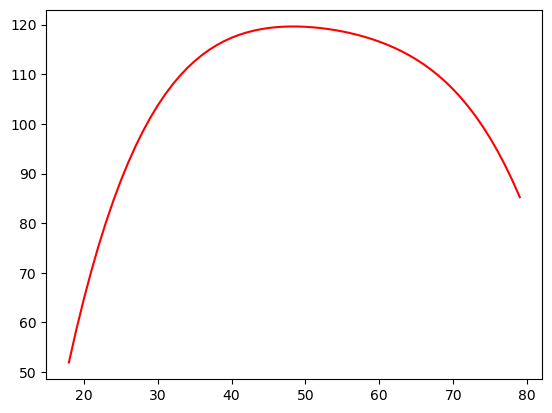

In [6]:
age_grid = np.arange(Wage.age.min(), Wage.age.max()).reshape(-1,1)
X_test = PolynomialFeatures(degree=n_deg).fit_transform(age_grid)
y_pred = reg.predict(X_test)

plt.plot(age_grid, y_pred, color='red')
plt.show()

Ok, mas qual é uma maneira rigorosa de escolher a ordem do polinômio? Existem várias alternativas. Uma delas é CV, mas no livro os autores sugerem um teste $F$. Vamos segui-los --- para isso usaremos o statsmodels, que dá a maneira mais conveniente de trabalhar com testes de hipótese.

In [7]:
X1 = PolynomialFeatures(1).fit_transform(X)
X2 = PolynomialFeatures(2).fit_transform(X)
X3 = PolynomialFeatures(3).fit_transform(X)
X4 = PolynomialFeatures(4).fit_transform(X)
X5 = PolynomialFeatures(5).fit_transform(X)

fit1 = sm.GLS(y, X1).fit()
fit2 = sm.GLS(y, X2).fit()
fit3 = sm.GLS(y, X3).fit()
fit4 = sm.GLS(y, X4).fit()
fit5 = sm.GLS(y, X5).fit()

In [8]:
print(sm.stats.anova_lm(fit1, fit2, fit3, fit4, fit5, type=1))

   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.593107  2.363850e-32
2    2996.0  4.777674e+06      1.0   15755.693664    9.888756  1.679202e-03
3    2995.0  4.771604e+06      1.0    6070.152124    3.809813  5.104620e-02
4    2994.0  4.770322e+06      1.0    1282.563017    0.804976  3.696820e-01


'\nThe above table, we fit five different models and sequentially compare the simpler model to the more complex model.\nThe summary above shows the quadratic model fit2 is significantly better than fit1 at p value of $2.36*10^{-32}$.\nSimilarly, the cubic model is significnatly better than the quadratic model ($p = 1.68 * 10^{-3}$).\nThe p-value comparing the cubic and degree-4 polynomials, fit3 and fit4, is approximately 0.05 \nwhile the degree-5 polynomial fit5 seems unnecessary because its p-value is 0.37. \nHence, either a cubic or a quartic polynomial appear to provide a reasonable fit to the data, \nbut lower- or higher-order models are not justified.\n'

Acima, rodamos cinco modelos aninhados (i.e., um sendo o subconjunto do outro) e comparamos os modelos do mais simples ao mais complexo. Indo do modelo linear para o quadrático, a estatística é bastante significativa: o $p$-valor é $2.36 \times 10^{-32}$. O modelo cúbico e quártico também são significativos, com $p$-valores, respectivamente $p = 1.68 * 10^{-3}$ e $p=0.05$. Mas o modelo de quinta ordem já não é mais significativo: o $p$-valor é 0.37. A partir daí, podemos escolher usar o modelo de terceira ou quarta ordem (mas provavelmente não é boa ideia usar modelos de primeira, segunda ou quinta ordem).

Para treinar um modelo polinomial, mas que não é linear, podemos usar GLMs. O código abaixo diz respeito a uma regressão logística de quarta ordem.

In [9]:
logistic_model = sm.GLM ((y>250), X4, family=sm.families.Binomial())
logistic_fit = logistic_model.fit()
print(logistic_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2995
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -350.61
Date:                Thu, 10 Nov 2022   Deviance:                       701.22
Time:                        16:46:38   Pearson chi2:                 3.70e+03
No. Iterations:                    10   Pseudo R-squ. (CS):           0.009724
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -109.5530     47.655     -2.299      0.0

Finalmente, para usar uma função-escada numa regressão, usamos a função `pd.cut()`. A partir dos `bins`, a função automaticamente escolhe os pontos de corte. Poderíamos ter feito isso explicitamente, através do argumento `breaks`.

In [13]:
age_cut, bins = pd.cut(Wage.age, bins=4, retbins=True, right=True)
age_cut.value_counts(sort=False)

(17.938, 33.5]     750
(33.5, 49.0]      1399
(49.0, 64.5]       779
(64.5, 80.0]        72
Name: age, dtype: int64

Agora, podemos criar dummies a partir das categorias. Vamos incluir um intercepto no modelo também.

In [14]:
age_cut_dummies = pd.get_dummies(age_cut)
age_cut_dummies = sm.add_constant(age_cut_dummies)
fit_age_cut = sm.GLM(Wage.wage, age_cut_dummies).fit()
print(fit_age_cut.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2996
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                          1634.1
Method:                          IRLS   Log-Likelihood:                -15353.
Date:                Thu, 10 Nov 2022   Deviance:                   4.8957e+06
Time:                        16:52:55   Pearson chi2:                 4.90e+06
No. Iterations:                     4   Pseudo R-squ. (CS):            0.06441
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             86.3984      1.061     81.

## 7.8.2 Splines

Vimos que é possível treinar modelos com splines construindo uma matriz apropriada de funções-base. A funçnao `bs()` gera essa matriz para splines com um conjunto de nós especificados. Por default, splines cúbicas são usadas. Nós vamos definir nós nas idades 25, 40, e 60 para produzir uma spline com seis funções-base.

In [15]:
age_grid = np.arange(Wage.age.min(), Wage.age.max()).reshape(-1,1)
spline_basis1 = dmatrix("bs(Wage.age, knots=(25,40,60), degree=3, include_intercept=False)", {"Wage.age": Wage.age}, return_type='dataframe')

In [16]:
# now we can fit the model using the spline basis functions
spline_fit1 = sm.GLM(Wage.wage, spline_basis1).fit()
spline_fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2993
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                          1594.0
Method:                          IRLS   Log-Likelihood:                -15314.
Date:                Thu, 10 Nov 2022   Deviance:                   4.7708e+06
Time:                        16:56:41   Pearson chi2:                 4.77e+06
No. Iterations:                     3   Pseudo R-squ. (CS):            0.09006
Covariance Type:            nonrobust                                         
==========================================================================================================================================
                                                                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                 60.4937      9.460      6.394      0.000      41.952      79.036
bs(Wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[0]     3.9805     12.538      0.317      0.751     -20.593      28.554
bs(Wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[1]    44.6310      9.626      4.636      0.000      25.764      63.498
bs(Wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[2]    62.8388     10.755      5.843      0.000      41.759      83.919
bs(Wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[3]    55.9908     10.706      5.230      0.000      35.007      76.975
bs(Wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[4]    50.6881     14.402      3.520      0.000      22.461      78.915
bs(Wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[5]    16.6061     19.126      0.868      0.385     -20.881      54.093
==========================================================================================================================================
"""

Outra possibilidade é escolher os graus de liberadade das splines e deixar o pacote escolher os nós.

In [17]:
spline_basis2 = dmatrix("bs(Wage.age, df=6, include_intercept=False)",
                        {"Wage.age": Wage.age}, return_type='dataframe')
spline_fit2 = sm.GLM(Wage.wage, spline_basis2).fit()
spline_fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2993
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                          1592.5
Method:                          IRLS   Log-Likelihood:                -15313.
Date:                Thu, 10 Nov 2022   Deviance:                   4.7662e+06
Time:                        16:59:11   Pearson chi2:                 4.77e+06
No. Iterations:                     3   Pseudo R-squ. (CS):            0.09101
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                         56.3138      7.258      7.759      0.000      42.088      70.539
bs(Wage.age, df=6, include_intercept=False)[0]    27.8240     12.435      2.238      0.025       3.453      52.195
bs(Wage.age, df=6, include_intercept=False)[1]    54.0625      7.127      7.585      0.000      40.093      68.032
bs(Wage.age, df=6, include_intercept=False)[2]    65.8284      8.323      7.909      0.000      49.515      82.142
bs(Wage.age, df=6, include_intercept=False)[3]    55.8127      8.724      6.398      0.000      38.714      72.911
bs(Wage.age, df=6, include_intercept=False)[4]    72.1315     13.745      5.248      0.000      45.192      99.071
bs(Wage.age, df=6, include_intercept=False)[5]    14.7509     16.209      0.910      0.363     -17.018      46.519
==================================================================================================================
"""

Há também a função `cr()` para rodar uma regressão com splines naturais.

In [18]:
spline_basis3 = dmatrix("cr(Wage.age, df=4)", {"Wage.age": Wage.age}, return_type='dataframe')
spline_fit3 = sm.GLM(Wage.wage, spline_basis3).fit()
spline_fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2996
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                          1596.4
Method:                          IRLS   Log-Likelihood:                -15318.
Date:                Thu, 10 Nov 2022   Deviance:                   4.7827e+06
Time:                        17:00:36   Pearson chi2:                 4.78e+06
No. Iterations:                     5   Pseudo R-squ. (CS):            0.08766
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                79.6421      1.773     44.918      0.000      76.167      83.117
cr(Wage.age, df=4)[0]   -14.6678      3.436     -4.269      0.000     -21.402      -7.934
cr(Wage.age, df=4)[1]    36.8111      1.950     18.881      0.000      32.990      40.632
cr(Wage.age, df=4)[2]    35.9349      2.056     17.476      0.000      31.905      39.965
cr(Wage.age, df=4)[3]    21.5639      6.989      3.085      0.002       7.865      35.263
=========================================================================================
"""

Vamos ver algumas previsões dos três modelos pautados em splines acima.

In [19]:
pred1 = spline_fit1.predict(dmatrix("bs(age_grid, knots=(25,40,60), include_intercept=False)",{"age_grid": age_grid}, return_type='dataframe'))
pred2 = spline_fit2.predict(dmatrix("bs(age_grid, df=6, include_intercept=False)",{"age_grid": age_grid}, return_type='dataframe'))
pred3 = spline_fit3.predict(dmatrix("cr(age_grid, df=4)", {"age_grid": age_grid}, return_type='dataframe'))

Podemos visualizar os três modelos num gráfico. A diferença só passa a ser significativa nos extremos.

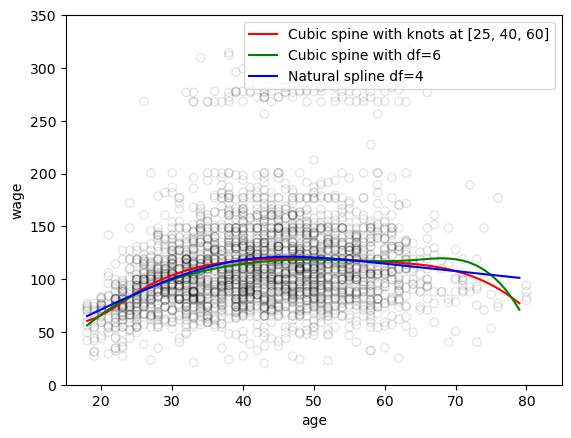

In [20]:
plt.scatter(Wage.age, Wage.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(age_grid, pred1, color='r', label='Cubic spine with knots at [25, 40, 60]')
plt.plot(age_grid, pred2, color='g', label='Cubic spine with df=6')
plt.plot(age_grid, pred3, color='b', label='Natural spline df=4')
plt.legend()
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage')
plt.show()

## 7.8.3 Modelos lineares generalizados

Vamos usar um modelo linear generalizado com features vindo de splines naturais de `year`, `age` e `education` (essa última feature sendo categórica).

In [21]:
age_basis = dmatrix("cr(Wage.age, df=5)", {"Wage.age": Wage.age}, return_type='dataframe')
year_basis = dmatrix("cr(Wage.year, df=4)", {"Wage.year": Wage.year}, return_type='dataframe').drop (['Intercept'], axis = 1)
education_dummies = pd.get_dummies(Wage.education)
education_dummies = education_dummies.drop([education_dummies.columns[0]], axis = 1)

X_all = pd.concat([age_basis, year_basis, education_dummies], axis=1)

In [23]:
gam1_fit = sm.OLS(Wage.wage, X_all).fit()
print(gam1_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     111.8
Date:                Thu, 10 Nov 2022   Prob (F-statistic):          2.63e-214
Time:                        17:06:42   Log-Likelihood:                -14933.
No. Observations:                3000   AIC:                         2.989e+04
Df Residuals:                    2988   BIC:                         2.996e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 52